### The Movie Database 5000 Movie Dataset

In this content-based filtering project I will build a function to generate movie recommendations based on their similarity to a user's chosen movie. Similarity will be calculated based on text features of each movie as found in the Movie Database 5000 Movie Dataset.

In [1]:
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
movies_df = pd.read_csv("../input/tmdb-movie-metadata/tmdb_5000_movies.csv")
credits_df = pd.read_csv("../input/tmdb-movie-metadata/tmdb_5000_credits.csv")

In [3]:
movies_df.head(3)

budget                                             genres  \
0  237000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
1  300000000  [{"id": 12, "name": "Adventure"}, {"id": 14, "...   
2  245000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   

                                       homepage      id  \
0                   http://www.avatarmovie.com/   19995   
1  http://disney.go.com/disneypictures/pirates/     285   
2   http://www.sonypictures.com/movies/spectre/  206647   

                                            keywords original_language  \
0  [{"id": 1463, "name": "culture clash"}, {"id":...                en   
1  [{"id": 270, "name": "ocean"}, {"id": 726, "na...                en   
2  [{"id": 470, "name": "spy"}, {"id": 818, "name...                en   

                             original_title  \
0                                    Avatar   
1  Pirates of the Caribbean: At World's End   
2                                   Spectre   

                                            overview  popularity  \
0  In the 22nd century, a paraplegic Marine is di...  150.437577   
1  Captain Barbossa, long believed to be dead, ha...  139.082615   
2  A cryptic message from Bond’s past sends him o...  107.376788   

                                production_companies  \
0  [{"name": "Ingenious Film Partners", "id": 289...   
1  [{"name": "Walt Disney Pictures", "id": 2}, {"...   
2  [{"name": "Columbia Pictures", "id": 5}, {"nam...   

                                production_countries release_date     revenue  \
0  [{"iso_3166_1": "US", "name": "United States o...   2009-12-10  2787965087   
1  [{"iso_3166_1": "US", "name": "United States o...   2007-05-19   961000000   
2  [{"iso_3166_1": "GB", "name": "United Kingdom"...   2015-10-26   880674609   

   runtime                                   spoken_languages    status  \
0    162.0  [{"iso_639_1": "en", "name": "English"}, {"iso...  Released   
1    169.0           [{"iso_639_1": "en", "name": "English"}]  Released   
2    148.0  [{"iso_639_1": "fr", "name": "Fran\u00e7ais"},...  Released   

                                          tagline  \
0                     Enter the World of Pandora.   
1  At the end of the world, the adventure begins.   
2                           A Plan No One Escapes   

                                      title  vote_average  vote_count  
0                                    Avatar           7.2       11800  
1  Pirates of the Caribbean: At World's End           6.9        4500  
2                                   Spectre           6.3        4466

In [4]:
credits_df.head(3)

movie_id                                     title  \
0     19995                                    Avatar   
1       285  Pirates of the Caribbean: At World's End   
2    206647                                   Spectre   

                                                cast  \
0  [{"cast_id": 242, "character": "Jake Sully", "...   
1  [{"cast_id": 4, "character": "Captain Jack Spa...   
2  [{"cast_id": 1, "character": "James Bond", "cr...   

                                                crew  
0  [{"credit_id": "52fe48009251416c750aca23", "de...  
1  [{"credit_id": "52fe4232c3a36847f800b579", "de...  
2  [{"credit_id": "54805967c3a36829b5002c41", "de...

The first thing to deal with is the json-like columns. These look like they will contain some useful information, but I won't be able to use them in their current format. Let's have a look at some examples.

In [5]:
movies_df.loc[0, 'genres']

'[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]'

In [6]:
movies_df.loc[0,'keywords']

'[{"id": 1463, "name": "culture clash"}, {"id": 2964, "name": "future"}, {"id": 3386, "name": "space war"}, {"id": 3388, "name": "space colony"}, {"id": 3679, "name": "society"}, {"id": 3801, "name": "space travel"}, {"id": 9685, "name": "futuristic"}, {"id": 9840, "name": "romance"}, {"id": 9882, "name": "space"}, {"id": 9951, "name": "alien"}, {"id": 10148, "name": "tribe"}, {"id": 10158, "name": "alien planet"}, {"id": 10987, "name": "cgi"}, {"id": 11399, "name": "marine"}, {"id": 13065, "name": "soldier"}, {"id": 14643, "name": "battle"}, {"id": 14720, "name": "love affair"}, {"id": 165431, "name": "anti war"}, {"id": 193554, "name": "power relations"}, {"id": 206690, "name": "mind and soul"}, {"id": 209714, "name": "3d"}]'

In [7]:
movies_df.loc[0,'production_companies']

'[{"name": "Ingenious Film Partners", "id": 289}, {"name": "Twentieth Century Fox Film Corporation", "id": 306}, {"name": "Dune Entertainment", "id": 444}, {"name": "Lightstorm Entertainment", "id": 574}]'

In [8]:
movies_df.loc[0,'production_countries']

'[{"iso_3166_1": "US", "name": "United States of America"}, {"iso_3166_1": "GB", "name": "United Kingdom"}]'

In [9]:
movies_df.loc[0,'spoken_languages']

'[{"iso_639_1": "en", "name": "English"}, {"iso_639_1": "es", "name": "Espa\\u00f1ol"}]'

In [10]:
credits_df.loc[0,'cast']

'[{"cast_id": 242, "character": "Jake Sully", "credit_id": "5602a8a7c3a3685532001c9a", "gender": 2, "id": 65731, "name": "Sam Worthington", "order": 0}, {"cast_id": 3, "character": "Neytiri", "credit_id": "52fe48009251416c750ac9cb", "gender": 1, "id": 8691, "name": "Zoe Saldana", "order": 1}, {"cast_id": 25, "character": "Dr. Grace Augustine", "credit_id": "52fe48009251416c750aca39", "gender": 1, "id": 10205, "name": "Sigourney Weaver", "order": 2}, {"cast_id": 4, "character": "Col. Quaritch", "credit_id": "52fe48009251416c750ac9cf", "gender": 2, "id": 32747, "name": "Stephen Lang", "order": 3}, {"cast_id": 5, "character": "Trudy Chacon", "credit_id": "52fe48009251416c750ac9d3", "gender": 1, "id": 17647, "name": "Michelle Rodriguez", "order": 4}, {"cast_id": 8, "character": "Selfridge", "credit_id": "52fe48009251416c750ac9e1", "gender": 2, "id": 1771, "name": "Giovanni Ribisi", "order": 5}, {"cast_id": 7, "character": "Norm Spellman", "credit_id": "52fe48009251416c750ac9dd", "gender": 

In [11]:
credits_df.loc[0,'crew']

'[{"credit_id": "52fe48009251416c750aca23", "department": "Editing", "gender": 0, "id": 1721, "job": "Editor", "name": "Stephen E. Rivkin"}, {"credit_id": "539c47ecc3a36810e3001f87", "department": "Art", "gender": 2, "id": 496, "job": "Production Design", "name": "Rick Carter"}, {"credit_id": "54491c89c3a3680fb4001cf7", "department": "Sound", "gender": 0, "id": 900, "job": "Sound Designer", "name": "Christopher Boyes"}, {"credit_id": "54491cb70e0a267480001bd0", "department": "Sound", "gender": 0, "id": 900, "job": "Supervising Sound Editor", "name": "Christopher Boyes"}, {"credit_id": "539c4a4cc3a36810c9002101", "department": "Production", "gender": 1, "id": 1262, "job": "Casting", "name": "Mali Finn"}, {"credit_id": "5544ee3b925141499f0008fc", "department": "Sound", "gender": 2, "id": 1729, "job": "Original Music Composer", "name": "James Horner"}, {"credit_id": "52fe48009251416c750ac9c3", "department": "Directing", "gender": 2, "id": 2710, "job": "Director", "name": "James Cameron"},

 All of these features look like they could be useful, with the exception of `spoken_languages`. The actual language of the movie is represented by the `original_language` column. This may well be an important factor in whether a user likes a movie or not, but the fact that another language is spoken at some point during the movie is unlikely to be important.
 
`Keywords` and `genres` are clearly going to be important for movie recommendations, so I will need to extract the `name` feature from these json-like entries. `Production_companies` and `Production_countries` may also be useful, as users may prefer movies from a certain company, such as Disney movies, or from a specific country. However, I will note that some of the entries have a lot of associated companies and countries. As there is no clear hierarchy to them I will need to use them all, which could ultimately confuse the model.

Finally, `cast` and `crew` look like they may be useful, but likely only some of the entries. Fortunately, the `cast` column appears to be sorted by order of actor/character importance, so I can simply take the five main actors. Similarly, the `crew` column contains each crew member's role, so I can simply extract the director. 
 
Although the entries look like json objects, due to the way Pandas reads the data from the CSV file they are actually strings. Therefore we will need to use a trick to extract the pertinent information. I am grateful to Abhishek Jaiswal for the following method method: https://www.analyticsvidhya.com/blog/2021/12/comprehensive-project-on-building-a-movie-recommender-website/

Originally in this project I used the method without any modifications. However, on generating recommendations for movies similar to 'Toy Story', one of the top recommendations was the film 'Everything You Always Wanted to Know About Sex (But Were Afraid to Ask)', not the first movie I would think of when recommending something to watch to a fan of Toy Story! I realised that this was happening due to the first name of the directory (Woody Allen) and the name of the main character in Toy Story (Woody). By joining first and last names of cast and crew (and production companies) into a single string I was able to avoid these problems.

In [12]:
def get_name(col):
    my_list = []
    for i in ast.literal_eval(col):
        my_list.append(i['name'])
    return my_list

def get_actors(col):
    count = 0
    my_list = []
    for i in ast.literal_eval(col):
        if count != 5:
            name = i['name']                            
            name = name.replace(" ","")  # Code edited to create single string from name
            my_list.append(name)
            count+=1
    return my_list

def get_director(col):
    my_list = []
    for i in ast.literal_eval(col):
        if i['job'] == 'Director':
            name = i['name']
            name = name.replace(" ","")  # Code edited to create single string from name
            my_list.append(name)
    return my_list

def get_company(col):
    my_list = []
    for i in ast.literal_eval(col):
        name = i['name']                            
        name = name.replace(" ","")  # Code edited to create single string from name
        my_list.append(name)
    return my_list

def get_country(col):
    my_list = []
    for i in ast.literal_eval(col):
        my_list.append(i["iso_3166_1"])
    return my_list

In [13]:
movies_df.genres = movies_df.genres.apply(get_name)
movies_df.keywords = movies_df.keywords.apply(get_name)
movies_df.production_countries = movies_df.production_countries.apply(get_country)
movies_df.production_companies = movies_df.production_companies.apply(get_company)
credits_df.cast = credits_df.cast.apply(get_actors)
credits_df.crew = credits_df.crew.apply(get_director)

Now we want to join the two datasets into a single dataframe. First I will check that movies in both datasets are the same

In [14]:
set(movies_df.id.unique() == credits_df.movie_id.unique())

{True}

As the movies are the same in both datasets, we can join the two together without worrying about introducing NAs.

In [15]:
credits_df.rename(columns={'movie_id':'id'}, inplace=True)
credits_df.drop(["title"], inplace=True, axis=1)
movies_df = movies_df.merge(credits_df, on='id')

Now I can drop some of the columns that I don't plan to use. As stated, this recommender project will be based on similarity of text. Therefore, I will drop all non-text columns. I will also drop `original_title` and `spoken_language`. The `title` column contains the important information relating to the movie title, and the language information is found in `original_language`, as discussed above. Finally, homepage is unlikely to be helpful for recommendations, so this will also be removed. 

In [16]:
movies_df.drop(["budget", "homepage", "popularity", "original_title", "release_date", 
                "revenue", "runtime", "spoken_languages", "vote_average", "vote_count"], axis=1, inplace=True)

How about `status`? What are the different options?

In [17]:
movies_df.status.unique()

array(['Released', 'Post Production', 'Rumored'], dtype=object)

We can recommend movies that are due to come out (those in post-production), but it doesn't really make sense to recommend movies that are only rumoured. Let's see how there are.

In [18]:
movies_df.status.value_counts()

Released           4795
Rumored               5
Post Production       3
Name: status, dtype: int64

Only five of the movies in the dataset are 'rumoured' movies, so it is no problem to drop them. I can then drop the `status` column too.

In [19]:
movies_df = movies_df.loc[movies_df.status != 'Rumored']
movies_df.drop("status", axis=1, inplace=True)

Now let's look at some general information on the dataframe.

In [20]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4798 entries, 0 to 4802
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   genres                4798 non-null   object
 1   id                    4798 non-null   int64 
 2   keywords              4798 non-null   object
 3   original_language     4798 non-null   object
 4   overview              4795 non-null   object
 5   production_companies  4798 non-null   object
 6   production_countries  4798 non-null   object
 7   tagline               3958 non-null   object
 8   title                 4798 non-null   object
 9   cast                  4798 non-null   object
 10  crew                  4798 non-null   object
dtypes: int64(1), object(10)
memory usage: 449.8+ KB


The info method shows that there are a large number of missing values in the `tagline` column, plus a small number in 'overview'. I will replace these NAs with a space.

In [21]:
movies_df.tagline = movies_df.tagline.fillna(" ")
movies_df.overview = movies_df.overview.fillna(" ")

In [22]:
movies_df.head(2)

genres     id  \
0  [Action, Adventure, Fantasy, Science Fiction]  19995   
1                   [Adventure, Fantasy, Action]    285   

                                            keywords original_language  \
0  [culture clash, future, space war, space colon...                en   
1  [ocean, drug abuse, exotic island, east india ...                en   

                                            overview  \
0  In the 22nd century, a paraplegic Marine is di...   
1  Captain Barbossa, long believed to be dead, ha...   

                                production_companies production_countries  \
0  [IngeniousFilmPartners, TwentiethCenturyFoxFil...             [US, GB]   
1  [WaltDisneyPictures, JerryBruckheimerFilms, Se...                 [US]   

                                          tagline  \
0                     Enter the World of Pandora.   
1  At the end of the world, the adventure begins.   

                                      title  \
0                                    Avatar   
1  Pirates of the Caribbean: At World's End   

                                                cast             crew  
0  [SamWorthington, ZoeSaldana, SigourneyWeaver, ...   [JamesCameron]  
1  [JohnnyDepp, OrlandoBloom, KeiraKnightley, Ste...  [GoreVerbinski]

Looking at the sample of the dataframe above, it is clear that the function used on the `genres`, `keywords`, etc. columns returned lists. For text processing it would be better if these were string, so I will convert them now.

In [23]:
def list_to_string(col):
    string = ' '.join([str(i) for i in col])
    return string

movies_df.genres = movies_df.genres.apply(list_to_string)
movies_df.keywords = movies_df.keywords.apply(list_to_string)
movies_df.production_companies = movies_df.production_companies.apply(list_to_string)
movies_df.production_countries = movies_df.production_countries.apply(list_to_string)
movies_df.cast = movies_df.cast.apply(list_to_string)
movies_df.crew = movies_df.crew.apply(list_to_string)

In [24]:
movies_df.head(2)

genres     id  \
0  Action Adventure Fantasy Science Fiction  19995   
1                  Adventure Fantasy Action    285   

                                            keywords original_language  \
0  culture clash future space war space colony so...                en   
1  ocean drug abuse exotic island east india trad...                en   

                                            overview  \
0  In the 22nd century, a paraplegic Marine is di...   
1  Captain Barbossa, long believed to be dead, ha...   

                                production_companies production_countries  \
0  IngeniousFilmPartners TwentiethCenturyFoxFilmC...                US GB   
1  WaltDisneyPictures JerryBruckheimerFilms Secon...                   US   

                                          tagline  \
0                     Enter the World of Pandora.   
1  At the end of the world, the adventure begins.   

                                      title  \
0                                    Avatar   
1  Pirates of the Caribbean: At World's End   

                                                cast           crew  
0  SamWorthington ZoeSaldana SigourneyWeaver Step...   JamesCameron  
1  JohnnyDepp OrlandoBloom KeiraKnightley Stellan...  GoreVerbinski

Before I get to the actual recommender phase, let's have a look at some of the most frequently occurring words in each of the columns. This can be done using a Word Cloud.

In [25]:
# Create a function that can be reused for each column. First I am going to create
# my own set of stopwords.

my_stopwords = text.ENGLISH_STOP_WORDS

def wc_generator(col):
    wc_text = " ".join(word for word in movies_df[col])
    wc = WordCloud(background_color = "white", max_words = 2000, max_font_size = 100, random_state = 3, 
              stopwords = my_stopwords, contour_width = 3).generate(wc_text)
    fig = plt.figure(figsize = (20, 10))
    plt.imshow(wc, interpolation = "bilinear")
    plt.axis("off")
    plt.show()

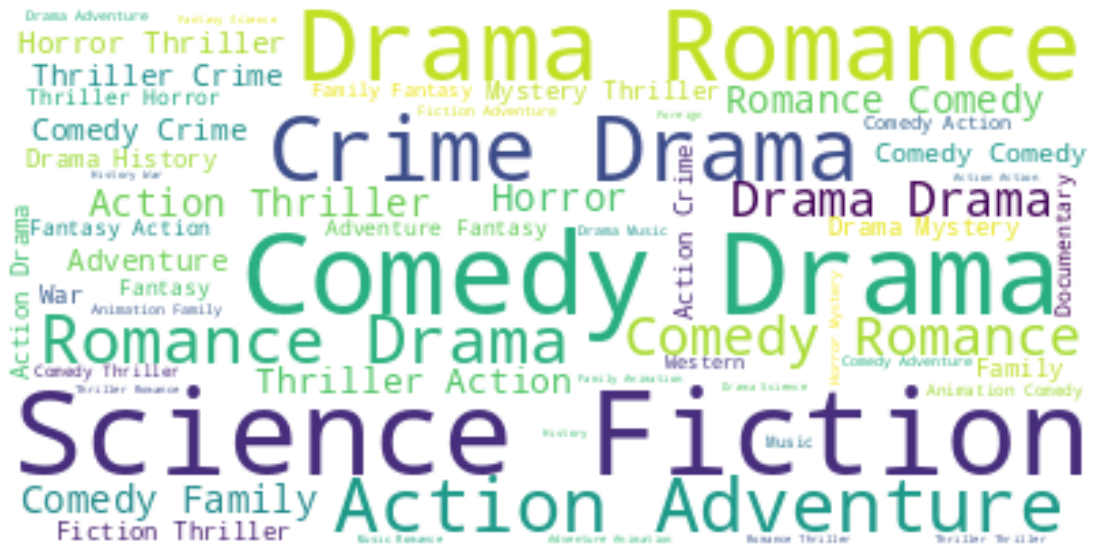

In [26]:
wc_generator("genres")

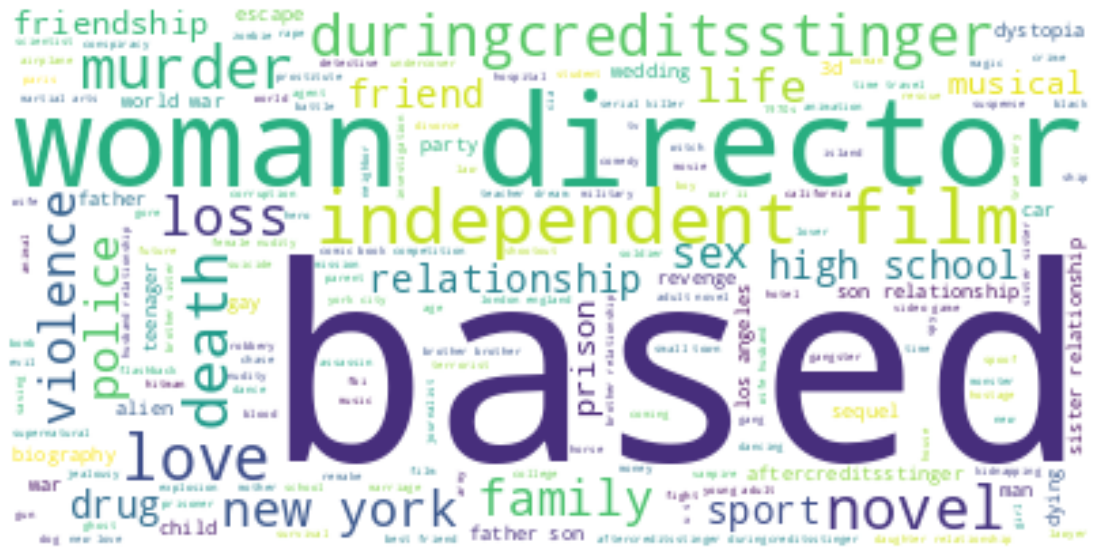

In [27]:
wc_generator("keywords")

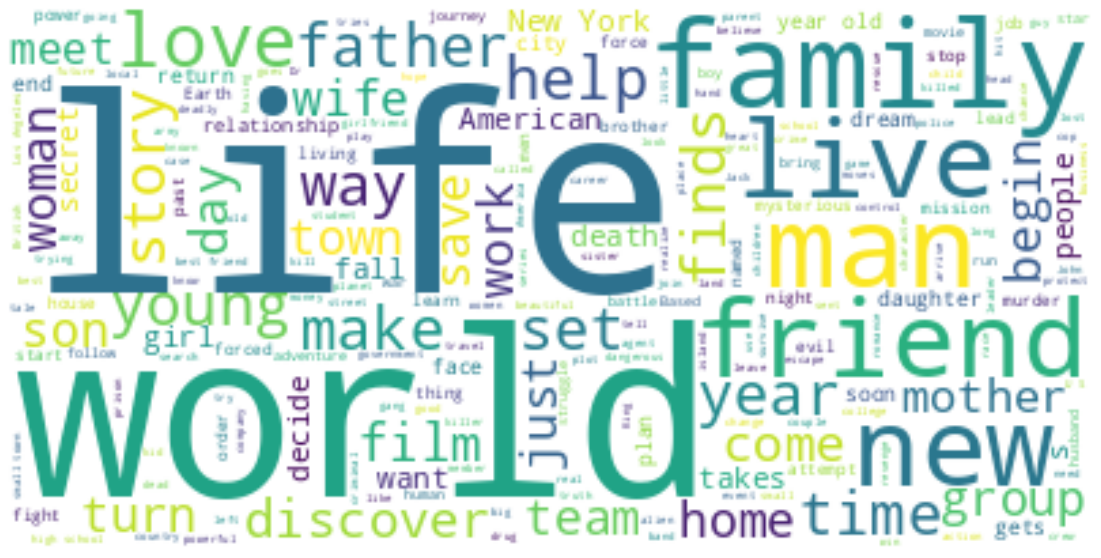

In [28]:
wc_generator("overview")

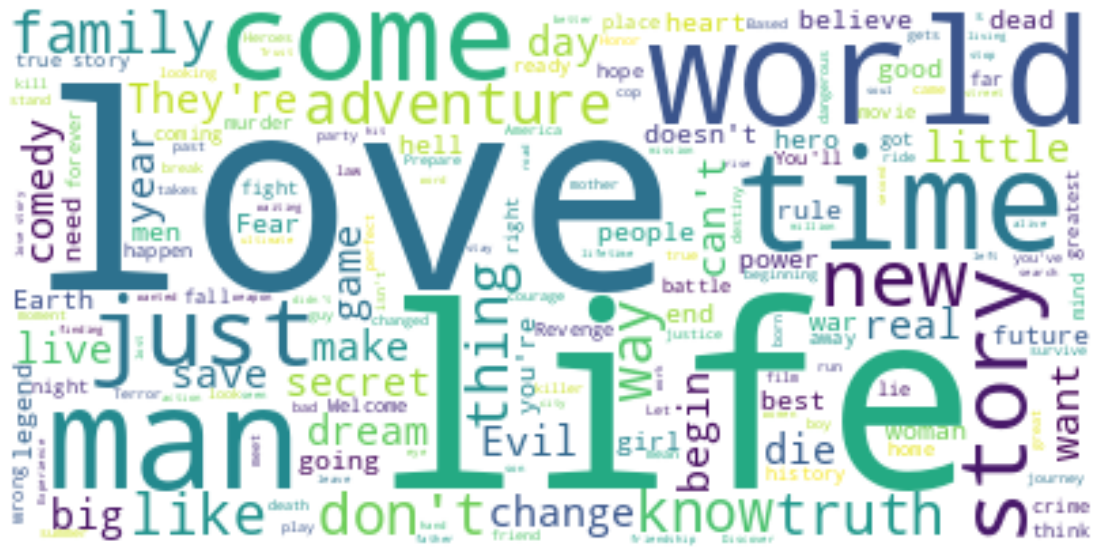

In [29]:
wc_generator("tagline")

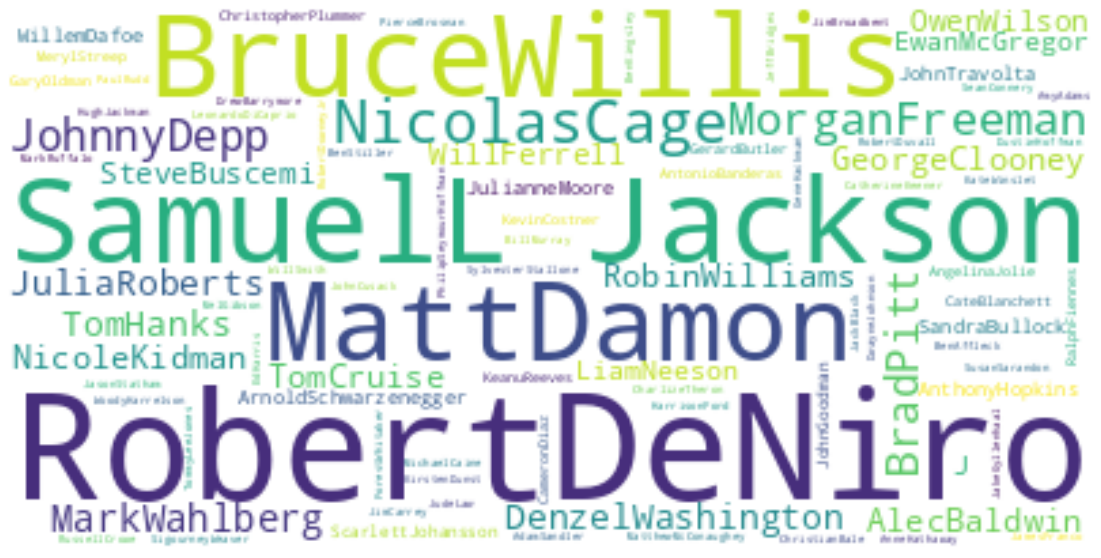

In [30]:
wc_generator("cast")

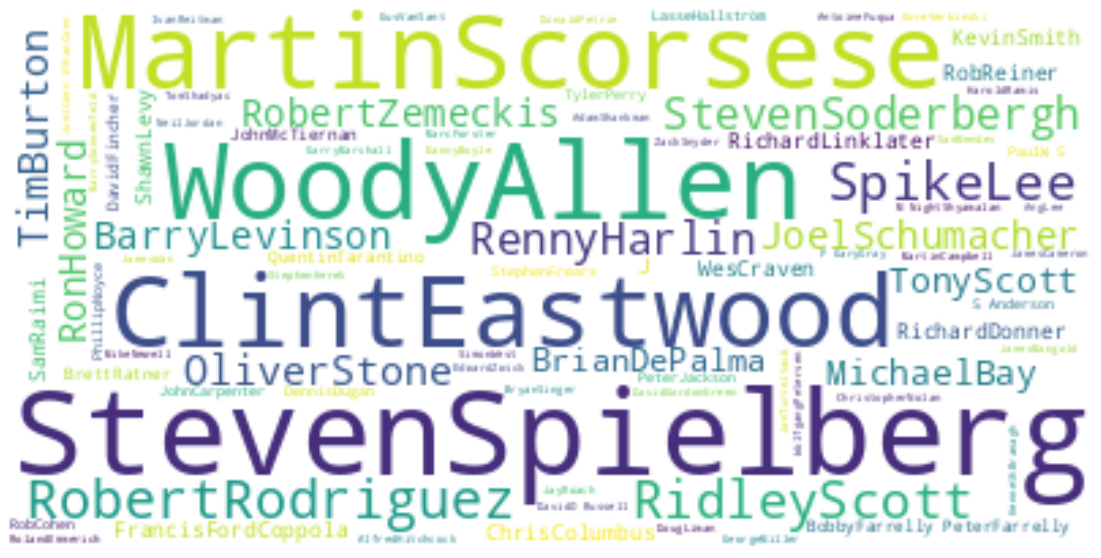

In [31]:
wc_generator("crew")

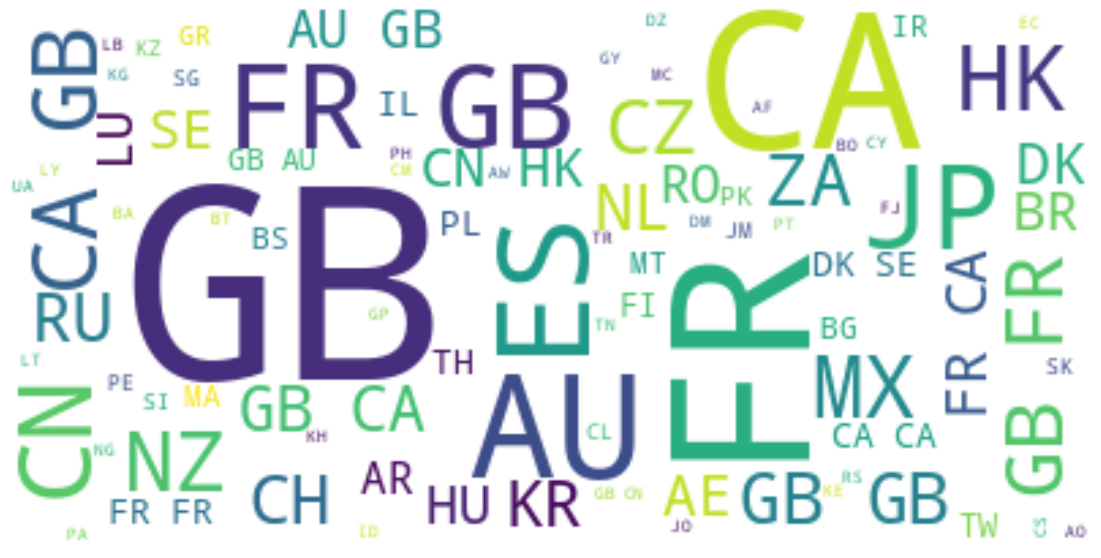

In [32]:
wc_generator("production_countries")

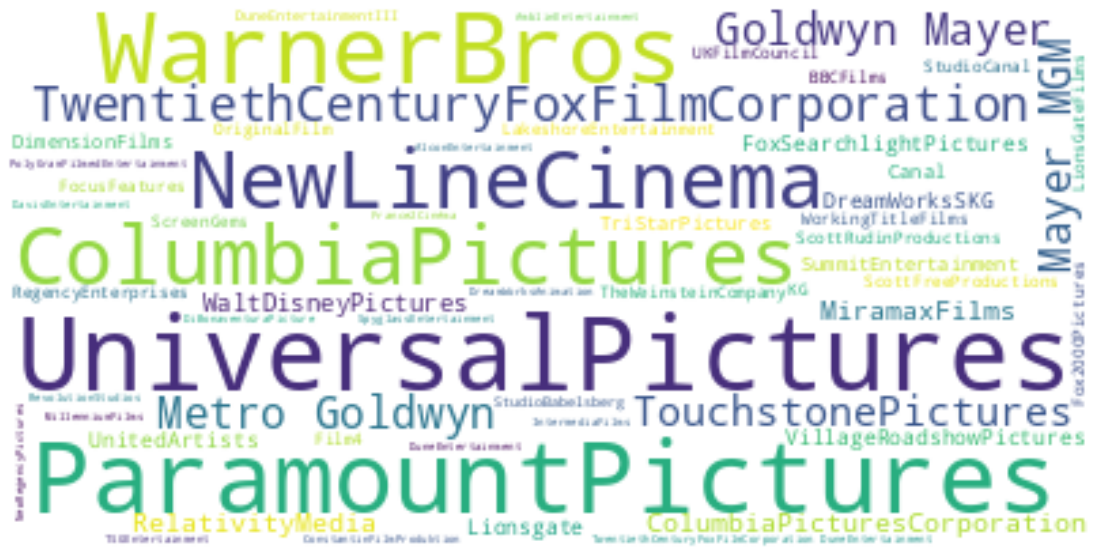

In [33]:
wc_generator("production_companies")

The word clouds generally look like we would expect. However, two things stand out to me. Firstly, the most frequently occurring keyword is 'based'. This is not going to be helpful when it comes to finding similarities between movies, so I will add it to the stopwords to be removed. Secondly, there is a notable omission from the production countries' word cloud: US. The reason it is missing is because the list of stopwords contains the word 'us'. I am therefore going to add one word to the stopwords and remove another. Because the stopwords list from Scikit learn is actually a frozenset, I will first create a set version, and then add/remove the words.

In [34]:
my_stopwords = set(my_stopwords)
my_stopwords.add('based')
my_stopwords.remove('us')

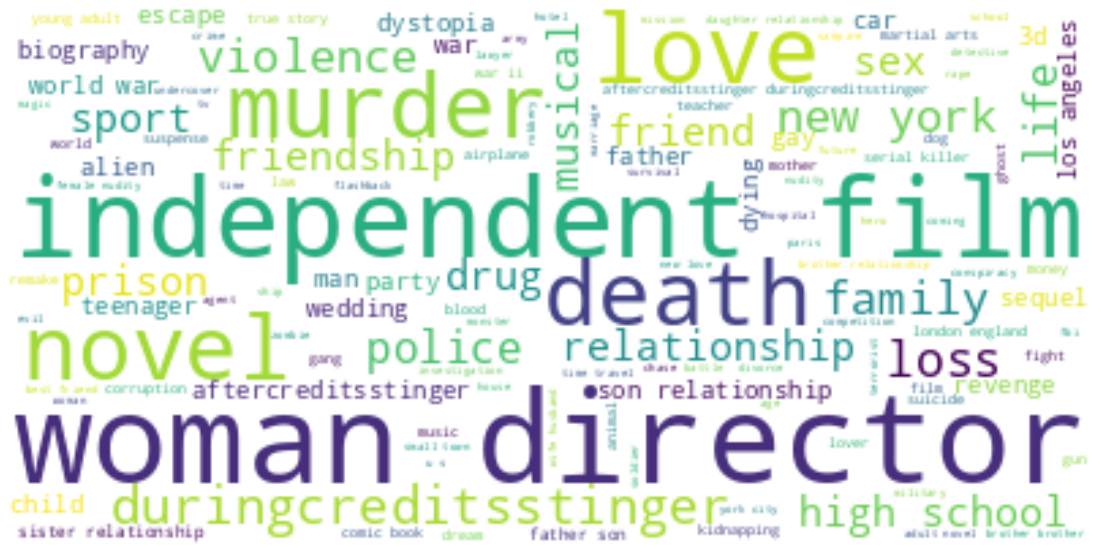

In [35]:
wc_generator("keywords")

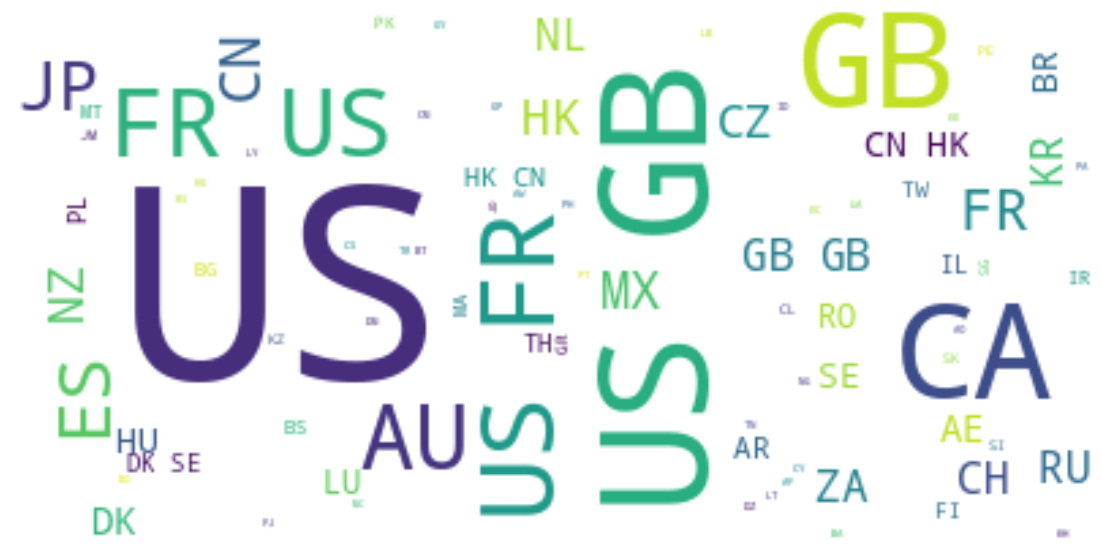

In [36]:
wc_generator("production_countries")

That looks better.

Now we can combine all of the text columns into a single column which will be used to create our feature vectors. I will create a copy of the original dataframe so that I can come back to it later.

In [37]:
text_df = movies_df.copy(deep=True)

text_df["text"] = text_df.genres+" "+text_df.keywords+" "+ \
                                " "+text_df.original_language+" "+text_df.overview+ \
                                " "+text_df.production_companies+" "+text_df.production_countries+ \
                                " "+text_df.tagline+" "+text_df.title+" "+text_df.cast+ \
                                " "+text_df.crew
text_df.drop(['genres', 'keywords', 'original_language', 'overview',
       'production_companies', 'production_countries', 'tagline',
       'cast', 'crew'], axis=1, inplace=True)

The first approach I will take is to use Term Frequency-Inverse Document Frequency to get a measure of how important each individual word is in the context of the whole set of words (corpus). Scikit-learn's TfidfVectorizer preforms preprocesing on the text, such as converting to lowercase and tokenising each word. I can pass my edited set of stopwords as an argument in order to remove the stopwords I just defined.

In [38]:
tfidf_vectorizer= TfidfVectorizer(stop_words=my_stopwords)
tfidf_matrix = tfidf_vectorizer.fit_transform(text_df.text)

To measure similarity I will use cosine similarity, a metric frequently used in text classification. Cosine distance measures the angle between vectors, with a small angle indicating that the vectors are similar. Cosine similarity is simply 1 - cosine distance, in order to give a more intuitive understanding of similarity (i.e. 1 = perfectly similar, 0 = no similarity).

For each movie in the dataset, I will calculate the cosine similarity between it and every other movie.

In [39]:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

Next, I create a new dataframe consisting of all of the similarities and using the index from the original dataframe.

In [40]:
recommendations_df = pd.DataFrame(cosine_sim, columns=text_df.title, index=text_df.title)

In [41]:
recommendations_df.iloc[0:5, 0:5]

title                                       Avatar  \
title                                                
Avatar                                    1.000000   
Pirates of the Caribbean: At World's End  0.025845   
Spectre                                   0.010616   
The Dark Knight Rises                     0.011351   
John Carter                               0.152208   

title                                     Pirates of the Caribbean: At World's End  \
title                                                                                
Avatar                                                                    0.025845   
Pirates of the Caribbean: At World's End                                  1.000000   
Spectre                                                                   0.011264   
The Dark Knight Rises                                                     0.012304   
John Carter                                                               0.055295   

title                                      Spectre  The Dark Knight Rises  \
title                                                                       
Avatar                                    0.010616               0.011351   
Pirates of the Caribbean: At World's End  0.011264               0.012304   
Spectre                                   1.000000               0.020518   
The Dark Knight Rises                     0.020518               1.000000   
John Carter                               0.011688               0.006865   

title                                     John Carter  
title                                                  
Avatar                                       0.152208  
Pirates of the Caribbean: At World's End     0.055295  
Spectre                                      0.011688  
The Dark Knight Rises                        0.006865  
John Carter                                  1.000000

As you would expect, the diagonal entries all equal to 1, as this is the movies' similarity with itself. The off-diagonal values show the similarities with other movies, which is what we are interested in.

I will now create a function that a user could use to generate as many recommendations as they like, ordered from most to least similar, excluding the original movie entered by the user.

In [42]:
def movie_recommender(movie, num_recommendations, database):
    temp_df = database[movie]
    temp_df = temp_df.sort_values(axis=0, ascending=False)
    for item in temp_df.index[1:num_recommendations+1]:
        print("Recommendation: \033[1m{}\033[0m \t Similarity: \033[1m{:.2%}\033[0m".format(item, temp_df[item]))

In [43]:
movie_recommender('Toy Story', 10, recommendations_df)

Recommendation: Toy Story 3 	 Similarity: 52.79%
Recommendation: Toy Story 2 	 Similarity: 52.12%
Recommendation: Small Soldiers 	 Similarity: 26.71%
Recommendation: The 40 Year Old Virgin 	 Similarity: 20.40%
Recommendation: Child's Play 	 Similarity: 16.23%
Recommendation: Man on the Moon 	 Similarity: 13.33%
Recommendation: Child's Play 2 	 Similarity: 11.97%
Recommendation: Big 	 Similarity: 11.74%
Recommendation: Factory Girl 	 Similarity: 11.65%
Recommendation: The Indian in the Cupboard 	 Similarity: 10.48%


The above results show that the recommender is working, at least to an extent. The first two movies returned look like solid recommendations, as Toy Story 2 and 3 are undoubtedly similar to Toy Story. Big and The Indian in the Cupboard also seem like acceptable recommendations, as they are both children's movies. Some of the other recommendations seem less suitable, such as The 40 year Old Virgin and Factory Girl. The most concerning recommendations, though, are Child's Play and Child's Play 2, two movies about a murderous doll! Let's have a look at the entries for our two movies.

In [44]:
movies_df[(movies_df.title == "Child's Play")|(movies_df.title == "Toy Story")]

genres     id  \
1541  Animation Comedy Family    862   
3167          Horror Thriller  10585   

                                               keywords original_language  \
1541  jealousy toy boy friendship friends rivalry bo...                en   
3167  gun birthday voodoo toy stalker murder blood s...                en   

                                               overview  \
1541  Led by Woody, Andy's toys live happily in his ...   
3167  A single mother gives her son a beloved doll f...   

       production_companies production_countries                    tagline  \
1541  PixarAnimationStudios                   US                              
3167          UnitedArtists                   US  Chucky is one mean S.O.B.   

             title                                               cast  \
1541     Toy Story  TomHanks TimAllen DonRickles JimVarney Wallace...   
3167  Child's Play  CatherineHicks ChrisSarandon AlexVincent BradD...   

              crew  
1541  JohnLasseter  
3167    TomHolland

Looking at the `keywords` column, the word 'toy' stands out. This is likely to be the reason for the similarity.

Another approach for representing text as vectors is the Bag of Words approach, which is essentially a count of how many times a word appears in the text. These vectors can be created using Scikit learn's CountVectorizer. Perhaps this will give a better result.

In [45]:
count_vectorizer= CountVectorizer(stop_words=my_stopwords)
count_matrix = count_vectorizer.fit_transform(text_df.text)

In [46]:
cosine_sim_count = cosine_similarity(count_matrix, count_matrix)
count_recommendations_df = pd.DataFrame(cosine_sim_count, columns=text_df.title, index=text_df.title)

In [47]:
movie_recommender('Toy Story', 10, count_recommendations_df)

Recommendation: Toy Story 2 	 Similarity: 53.24%
Recommendation: Toy Story 3 	 Similarity: 52.22%
Recommendation: Small Soldiers 	 Similarity: 30.07%
Recommendation: The 40 Year Old Virgin 	 Similarity: 22.10%
Recommendation: Child's Play 	 Similarity: 20.66%
Recommendation: The Indian in the Cupboard 	 Similarity: 19.38%
Recommendation: Child's Play 2 	 Similarity: 19.06%
Recommendation: Big 	 Similarity: 18.60%
Recommendation: Man on the Moon 	 Similarity: 18.35%
Recommendation: The Boxtrolls 	 Similarity: 16.40%


In fact, the Bag of Words approach has actually suggested a greater similarity between Toy Story and Child's Play than the TF-IDF approach.

One other thing that we can try to see if our model improves it to use less features. Feature such as the title, production country and production company may actually be confusing the model. I will try again without these features to see if the results change. As we won't be using production country anymore, we can add 'us' back into the stopwords.

In [48]:
my_stopwords.add('us')

In [49]:
smaller_text_df = movies_df.copy(deep=True)
smaller_text_df["text"] = smaller_text_df.genres+" "+smaller_text_df.keywords+" "+ \
                                " "+smaller_text_df.overview+" "+smaller_text_df.tagline \
                                +" "+smaller_text_df.cast+" "+smaller_text_df.crew
smaller_text_df.drop(['genres', 'keywords', 'original_language', 'overview',
       'production_companies', 'production_countries', 'tagline',
       'cast', 'crew'], axis=1, inplace=True)

In [50]:
tfidf_vectorizer= TfidfVectorizer(stop_words=my_stopwords)
tfidf_matrix = tfidf_vectorizer.fit_transform(smaller_text_df.text)

In [51]:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
recommendations_df = pd.DataFrame(cosine_sim, columns=smaller_text_df.title, index=smaller_text_df.title)

In [52]:
movie_recommender('Toy Story', 10, recommendations_df)

Recommendation: Toy Story 2 	 Similarity: 47.63%
Recommendation: Toy Story 3 	 Similarity: 47.23%
Recommendation: Small Soldiers 	 Similarity: 23.13%
Recommendation: The 40 Year Old Virgin 	 Similarity: 22.64%
Recommendation: Man on the Moon 	 Similarity: 14.37%
Recommendation: Child's Play 	 Similarity: 13.98%
Recommendation: Factory Girl 	 Similarity: 12.56%
Recommendation: The Indian in the Cupboard 	 Similarity: 11.46%
Recommendation: Child's Play 2 	 Similarity: 10.88%
Recommendation: Big 	 Similarity: 10.40%


In [53]:
count_vectorizer= CountVectorizer(stop_words='english')
count_matrix = count_vectorizer.fit_transform(smaller_text_df.text)

In [54]:
cosine_sim_count = cosine_similarity(count_matrix, count_matrix)
count_recommendations_df = pd.DataFrame(cosine_sim_count, columns=smaller_text_df.title, index=smaller_text_df.title)

In [55]:
movie_recommender('Toy Story', 10, count_recommendations_df)

Recommendation: Toy Story 2 	 Similarity: 47.33%
Recommendation: Toy Story 3 	 Similarity: 45.07%
Recommendation: Small Soldiers 	 Similarity: 25.56%
Recommendation: The 40 Year Old Virgin 	 Similarity: 23.08%
Recommendation: The Indian in the Cupboard 	 Similarity: 19.10%
Recommendation: Man on the Moon 	 Similarity: 17.01%
Recommendation: Child's Play 	 Similarity: 16.59%
Recommendation: Big 	 Similarity: 16.24%
Recommendation: Child's Play 2 	 Similarity: 15.91%
Recommendation: CJ7 	 Similarity: 15.44%


This hasn't had much of an effect on the recommender. Let's have a look at a few other recommendations. I will use the TF-IDF model.

In [56]:
movie_recommender('Alien', 10, recommendations_df)

Recommendation: Avatar 	 Similarity: 24.15%
Recommendation: Alien³ 	 Similarity: 24.02%
Recommendation: Aliens 	 Similarity: 23.62%
Recommendation: Moonraker 	 Similarity: 23.30%
Recommendation: Meet Dave 	 Similarity: 21.82%
Recommendation: Mission to Mars 	 Similarity: 21.27%
Recommendation: Event Horizon 	 Similarity: 21.24%
Recommendation: Silent Running 	 Similarity: 20.07%
Recommendation: Cargo 	 Similarity: 18.41%
Recommendation: The Martian 	 Similarity: 18.39%


In [57]:
movie_recommender('Jurassic Park', 10, recommendations_df)

Recommendation: Jurassic World 	 Similarity: 51.18%
Recommendation: The Lost World: Jurassic Park 	 Similarity: 32.62%
Recommendation: Jurassic Park III 	 Similarity: 30.76%
Recommendation: Vacation 	 Similarity: 22.46%
Recommendation: The Land Before Time 	 Similarity: 15.80%
Recommendation: The Way Way Back 	 Similarity: 15.23%
Recommendation: The Nut Job 	 Similarity: 15.07%
Recommendation: Beverly Hills Cop III 	 Similarity: 14.64%
Recommendation: Walking With Dinosaurs 	 Similarity: 13.80%
Recommendation: Adventureland 	 Similarity: 13.40%


In [58]:
movie_recommender('The Godfather', 10, recommendations_df)

Recommendation: The Godfather: Part II 	 Similarity: 33.33%
Recommendation: The Godfather: Part III 	 Similarity: 21.65%
Recommendation: Blood Ties 	 Similarity: 17.24%
Recommendation: Mickey Blue Eyes 	 Similarity: 13.76%
Recommendation: Mambo Italiano 	 Similarity: 13.12%
Recommendation: Captain Corelli's Mandolin 	 Similarity: 12.97%
Recommendation: GoodFellas 	 Similarity: 12.87%
Recommendation: Summer of Sam 	 Similarity: 12.53%
Recommendation: Eulogy 	 Similarity: 11.61%
Recommendation: Letters to Juliet 	 Similarity: 11.07%


The results show us the limitations of the recommender. It does seem to be able to pick up on general themes, hence recommending movies set in space for Alien, movies with dinosaurs for Jurassic Park, and movies involving the Mafia for The Godfather. In particular, the top one or two results do appear to be good recommendations. However, beyond this, the recommender seems to give too little weight to the movie genre, for example when faced with The Godfather it gives a higher recommendation to the comedy Micky Blues Eyes than it gives to the much more similar film Goodfellas. It also fails to take into account whether the movie is appropriate for adults or children.

If i were to expand on this project, I would look to give more weight to genre, as well as adding a feature indicating whether the film was for adults or children.